<a href="https://colab.research.google.com/github/alwiyahya99/MachineLearning/blob/main/Submission_Proyek_Akhir_Image_Classification_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Submission Proyek Akhir : Image Classification Model Deployment**

**Nama : Alwi Yahya Muljabar**

**Dataset : rice-image-dataset-train-test-split.zip**

**Sumber : Kaggle**

**Link Dataset : https://www.kaggle.com/datasets/ayanwap7/rice-image-dataset-train-test-split**

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ayanwap7/rice-image-dataset-train-test-split

Saving kaggle.json to kaggle.json
 99% 217M/220M [00:10<00:00, 28.1MB/s]
100% 220M/220M [00:10<00:00, 22.7MB/s]


In [ ]:
!unzip -qq rice-image-dataset-train-test-split.zip

In [ ]:
import os

rice = 'Rice_Image_Dataset/test'

classes = os.listdir(rice)
jum_total = 0

for nama_class in classes:
  class_path = os.path.join(rice, nama_class)
  jum_images = len(os.listdir(class_path))
  print(f"{class_path} : {jum_images}")
  jum_total += jum_images

print(jum_total)
list_rice = os.listdir(rice)

Rice_Image_Dataset/test/Ipsala : 3000
Rice_Image_Dataset/test/Karacadag : 3000
Rice_Image_Dataset/test/Basmati : 3000
Rice_Image_Dataset/test/Jasmine : 3000
Rice_Image_Dataset/test/Arborio : 3000
15000


In [ ]:
print(list_rice)

['Ipsala', 'Karacadag', 'Basmati', 'Jasmine', 'Arborio']


In [ ]:
class_rice = len(list_rice)
i_shape = 150,150
batch_size = 256

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = 0.2
)


In [ ]:
train_generator = Train_datagen.flow_from_directory(
    rice,
    target_size = (i_shape),
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True,
    subset = "training"
)

validation_generator = Train_datagen.flow_from_directory(
    rice,
    target_size = (i_shape),
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = False,
    subset = "validation"
)

Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


In [ ]:
import tensorflow as tf

accuracy = 92e-2
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= accuracy and logs.get('val_accuracy')>accuracy):
      print('\nEpoch = ',epoch,
            '\nAkurasi : %2.2f%%' %(logs['accuracy']*100),
            '\nVal_Akurasi : %2.2f%%' %(logs['val_accuracy']*100),
            '\nTraining berhenti')
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, models
import numpy as np
# from tensorflow.keras import applications, optimizers

pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(last_output)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)

x = layers.Dense(class_rice, activation='softmax')(x)

model = models.Model(pre_trained_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
num_epochs = 100

H = model.fit(train_generator,
              epochs=num_epochs,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator,
              validation_steps = validation_generator.samples // batch_size,
              verbose = 1,
              callbacks=[callbacks])

Epoch 1/100
46/46 [==============================] - 524s 11s/step - loss: 0.2856 - accuracy: 0.8980 - val_loss: 0.0473 - val_accuracy: 0.9854
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9765
Epoch =  1 
Akurasi : 97.65% 
Val_Akurasi : 96.95% 
Training berhenti
46/46 [==============================] - 461s 10s/step - loss: 0.0705 - accuracy: 0.9765 - val_loss: 0.0886 - val_accuracy: 0.9695


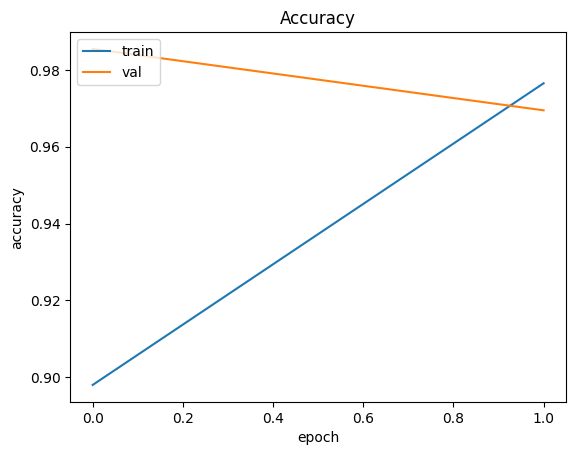

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

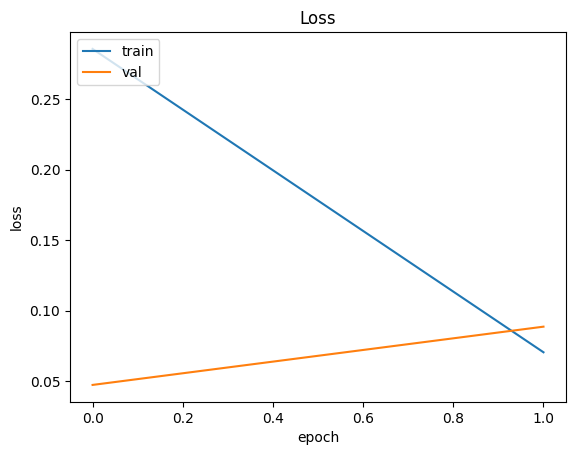

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import pathlib
os.mkdir("model_save")

export_dir = 'model_save/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('rice.tflite')
tflite_model_file.write_bytes(tflite_model)

12963736

In [ ]:
!ls

kaggle.json  Rice_Image_Dataset			      rice.tflite
model_save   rice-image-dataset-train-test-split.zip  sample_data
